In [1]:
import pytest
from jax import config, devices

config.update("jax_enable_x64", True)

import yaml, mlflow, os, tempfile, time
import numpy as np
from equinox import filter_jit
import matplotlib.pyplot as plt
from flatten_dict import flatten, unflatten

from tsadar.utils import misc
from tsadar.core.thomson_diagnostic import ThomsonScatteringDiagnostic
from tsadar.core.modules import ThomsonParams
from tsadar.utils.data_handling.calibration import get_scattering_angles, get_calibrations


# def test_arts2d_forward_pass():
#     """
#     Runs a forward pass with the Thomson scattering diagnostic and ThomsonParams classes. Saves the results to mlflow.


#     Args:
#         config: Dictionary - Configuration dictionary created from the input deck

#     Returns:
#         Ion data, electron data, and plots are saved to mlflow

#     """

#     if not any(["gpu" == device.platform for device in devices()]):
#         pytest.skip("Takes too long without a GPU")

#     mlflow.set_experiment("tsadar-tests")
#     with mlflow.start_run(run_name="test_arts2d_fwd") as run:
#         with tempfile.TemporaryDirectory() as td:

#             t0 = time.time()
#             with open("tests/configs/arts2d_test_defaults.yaml", "r") as fi:
#                 defaults = yaml.safe_load(fi)

#             with open("tests/configs/arts2d_test_inputs.yaml", "r") as fi:
#                 inputs = yaml.safe_load(fi)

#             defaults = flatten(defaults)
#             defaults.update(flatten(inputs))
#             config = unflatten(defaults)

#             with open(os.path.join(td, "config.yaml"), "w") as fi:
#                 yaml.dump(config, fi)

#             # get scattering angles and weights
#             config["other"]["lamrangE"] = [
#                 config["data"]["fit_rng"]["forward_epw_start"],
#                 config["data"]["fit_rng"]["forward_epw_end"],
#             ]
#             config["other"]["lamrangI"] = [
#                 config["data"]["fit_rng"]["forward_iaw_start"],
#                 config["data"]["fit_rng"]["forward_iaw_end"],
#             ]
#             config["other"]["npts"] = int(config["other"]["CCDsize"][1] * config["other"]["points_per_pixel"])
#             sas = get_scattering_angles(config)

#             [axisxE, _, _, _, _, _] = get_calibrations(
#                 104000, config["other"]["extraoptions"]["spectype"], 0.0, config["other"]["CCDsize"]
#             )  # shot number hardcoded to get calibration
#             config["other"]["extraoptions"]["spectype"] = "angular_full"

#             sas["angAxis"] = axisxE

#             dummy_batch = {
#                 "i_data": np.ones((config["other"]["CCDsize"][0], config["other"]["CCDsize"][1])),
#                 "e_data": np.ones((config["other"]["CCDsize"][0], config["other"]["CCDsize"][1])),
#                 "noise_e": np.array([0]),
#                 "noise_i": np.array([0]),
#                 "e_amps": np.array([1]),
#                 "i_amps": np.array([1]),
#             }

#             ts_diag = ThomsonScatteringDiagnostic(config, scattering_angles=sas)
#             ts_params = ThomsonParams(config["parameters"], num_params=1, batch=False)
#             ThryE, ThryI, lamAxisE, lamAxisI = ts_diag(ts_params, dummy_batch)
#             # np.save("tests/test_forward/ThryE-arts2d.npy", ThryE)

#             ground_truth = np.load("tests/test_forward/ThryE-arts2d.npy")

#             misc.log_mlflow(config)

#             plot_fwd_vs_ground_truth(td, ts_params, ThryE, ground_truth)
#             mlflow.log_artifacts(td)

#         mlflow.log_metric("runtime-sec", time.time() - t0)

#         # np.testing.assert_allclose(ThryE, ground_truth, rtol=1e-4)
#     misc.export_run(run.info.run_id)


# def plot_fwd_vs_ground_truth(td, ts_params, ThryE, ground_truth):
#     # logging.info("Plotting model vs ground truth")

#     fig, ax = plt.subplots(1, 3, figsize=(11, 4), tight_layout=True)
#     c = ax[0].contourf(np.squeeze(ThryE).T, levels=np.linspace(0, 2.5, 26))
#     fig.colorbar(c)
#     c = ax[1].contourf(np.squeeze(ground_truth).T, levels=np.linspace(0, 2.5, 26))
#     fig.colorbar(c)
#     c = ax[2].contourf((np.squeeze(ground_truth) - np.squeeze(ThryE)).T, levels=np.linspace(0, 2.5, 26))
#     fig.colorbar(c)

#     ax[0].set_title("Model")
#     ax[1].set_title("Ground Truth")
#     ax[2].set_title("Model - Ground Truth")
#     fig.savefig(os.path.join(td, "ThryE.png"), bbox_inches="tight")

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
#     ax[0].plot(ts_params.electron.distribution_functions.get_f00())
#     ax[0].grid()
#     ax[1].semilogy(ts_params.electron.distribution_functions.get_f00())
#     ax[1].grid()
#     fig.savefig(os.path.join(td, "f00.png"), bbox_inches="tight")

#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
#     ax.plot(ts_params.electron.distribution_functions.flm[1][0] * ts_params.electron.distribution_functions.get_f00())
#     ax.grid()
#     fig.savefig(os.path.join(td, "f10.png"), bbox_inches="tight")

#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
#     ax.plot(ts_params.electron.distribution_functions.flm[1][1] * ts_params.electron.distribution_functions.get_f00())
#     ax.grid()
#     fig.savefig(os.path.join(td, "f11.png"), bbox_inches="tight")
#     # np.testing.assert_allclose(ThryE, ground_truth["ThryE"], atol=0.01, rtol=0)


In [2]:

with open("tests/configs/arts2d_test_defaults.yaml", "r") as fi:
    defaults = yaml.safe_load(fi)

with open("tests/configs/arts2d_test_inputs.yaml", "r") as fi:
    inputs = yaml.safe_load(fi)

defaults = flatten(defaults)
defaults.update(flatten(inputs))
config = unflatten(defaults)

# get scattering angles and weights
config["other"]["lamrangE"] = [
    config["data"]["fit_rng"]["forward_epw_start"],
    config["data"]["fit_rng"]["forward_epw_end"],
]
config["other"]["lamrangI"] = [
    config["data"]["fit_rng"]["forward_iaw_start"],
    config["data"]["fit_rng"]["forward_iaw_end"],
]
config["other"]["npts"] = int(config["other"]["CCDsize"][1] * config["other"]["points_per_pixel"])

sas = get_scattering_angles(config)

[axisxE, _, _, _, _, _] = get_calibrations(
    104000, config["other"]["extraoptions"]["spectype"], 0.0, config["other"]["CCDsize"]
)  # shot number hardcoded to get calibration
config["other"]["extraoptions"]["spectype"] = "angular_full"

sas["angAxis"] = axisxE

In [3]:

dummy_batch = {
    "i_data": np.ones((config["other"]["CCDsize"][0], config["other"]["CCDsize"][1])),
    "e_data": np.ones((config["other"]["CCDsize"][0], config["other"]["CCDsize"][1])),
    "noise_e": np.array([0]),
    "noise_i": np.array([0]),
    "e_amps": np.array([1]),
    "i_amps": np.array([1]),
}
config["parameters"]["electron"]["fe"]["params"]["nvr"] = 64
config["parameters"]["electron"]["fe"]["nvx"] = 512

In [4]:
config["parameters"]["electron"]["fe"]["params"]["init_m"] = m = 2.0
config["parameters"]["electron"]["fe"]["params"]["LTx"] = LTx = 1e16
config["parameters"]["electron"]["fe"]["params"]["LTy"] = LTy = 1e16
ts_diag = ThomsonScatteringDiagnostic(config, scattering_angles=sas)
ts_params = ThomsonParams(config["parameters"], num_params=1, batch=False)
ThryE, ThryI, lamAxisE, lamAxisI = ts_diag(ts_params, dummy_batch)

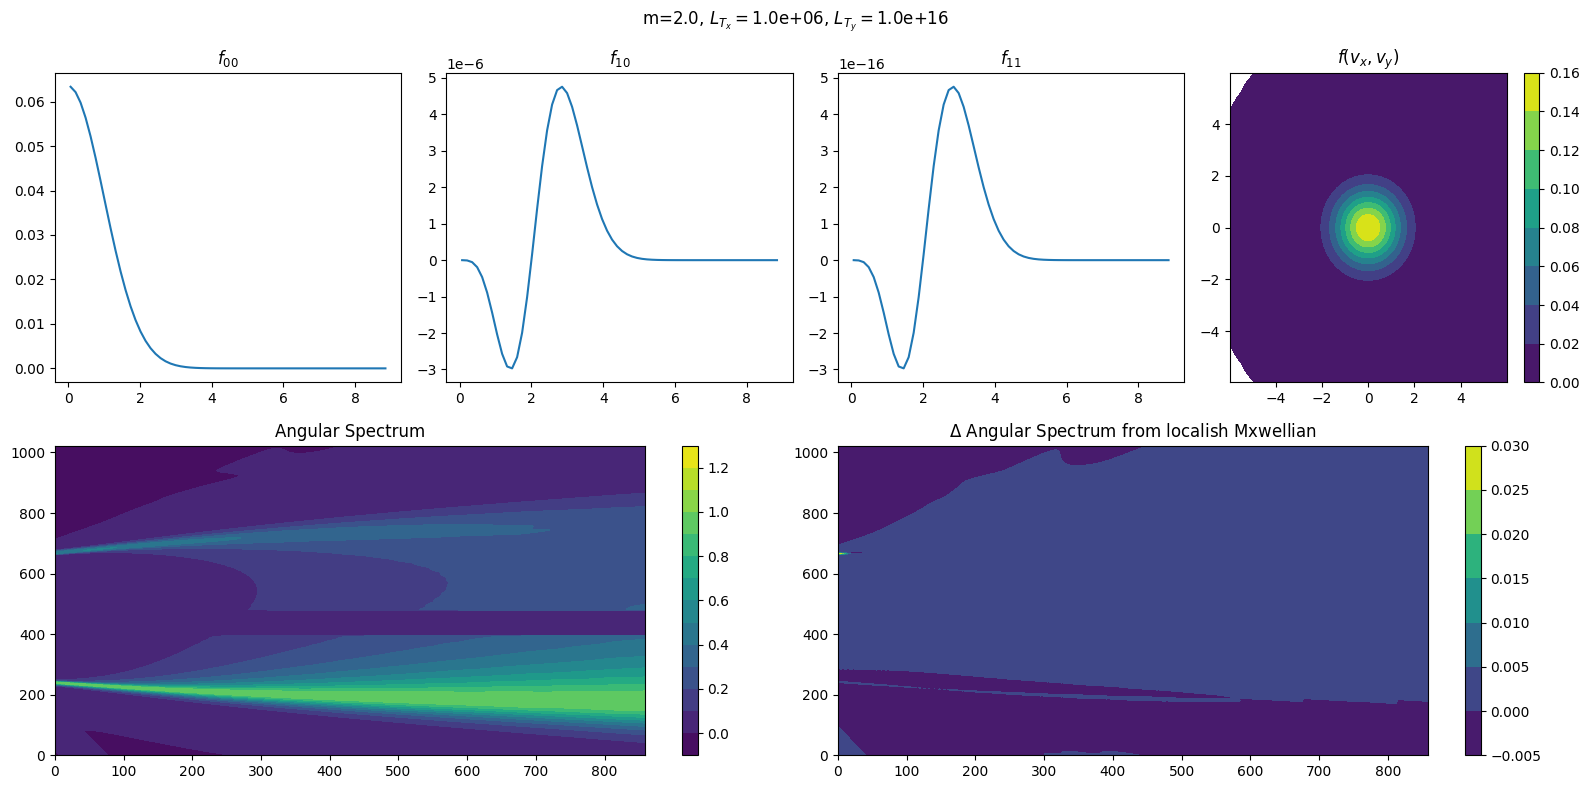

In [5]:
config["parameters"]["electron"]["fe"]["params"]["init_m"] = m = 2.0
config["parameters"]["electron"]["fe"]["params"]["LTx"] = LTx = 1e6
config["parameters"]["electron"]["fe"]["params"]["LTy"] = LTy = 1e16
ts_diag = ThomsonScatteringDiagnostic(config, scattering_angles=sas)
ts_params = ThomsonParams(config["parameters"], num_params=1, batch=False)
pThryE, ThryI, lamAxisE, lamAxisI = ts_diag(ts_params, dummy_batch)
# make a grid spec in which the first row has two plots and the second row has one plot
# Define the GridSpec
f00 = ts_params.electron.distribution_functions.get_f00()
vx = ts_params.electron.distribution_functions.vx
fvxvy = ts_params.electron.distribution_functions()

from matplotlib import gridspec
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
fig = plt.figure(figsize=(16, 8), tight_layout=True)
vr = ts_params.electron.distribution_functions.vr

# First row: Two plots
ax1 = fig.add_subplot(gs[0, 0])  # First plot in the first row
ax2 = fig.add_subplot(gs[0, 1])  # Second plot in the first row
ax3 = fig.add_subplot(gs[0, 2])  # Second plot in the first row
ax4 = fig.add_subplot(gs[0, 3])  # Second plot in the first row

# Second row: One plot spanning two columns
ax5 = fig.add_subplot(gs[1, :2])  # Single plot span
ax6 = fig.add_subplot(gs[1, 2:])  # Single plot span

# fig, ax = plt.subplots(2, 2, figsize=(10, 4), tight_layout=True)
c = ax5.contourf(pThryE.T, levels=np.linspace(-0.1, 1.3, 15))
ax5.set_title("Angular Spectrum")
fig.colorbar(c)

c = ax6.contourf((pThryE-ThryE).T)
ax6.set_title("$\Delta$ Angular Spectrum from localish Mxwellian")
fig.colorbar(c)

ax1.plot(vr, ts_params.electron.distribution_functions.get_f00())
ax1.set_title("$f_{00}$")
ax2.plot(vr, ts_params.electron.distribution_functions.flm[1][0] * f00)
ax2.set_title("$f_{10}$")
ax3.plot(vr, ts_params.electron.distribution_functions.flm[1][1] * f00)
ax3.set_title("$f_{11}$")
c = ax4.contourf(vx, vx, fvxvy)
ax4.set_title("$f(v_x, v_y)$")
fig.colorbar(c)
fig.suptitle(f"m={m:.1f}" + ", $L_{T_x} =$" + f"{LTx:.1e}" + ", $L_{T_y} = $" + f"{LTy:.1e}")
fig.savefig(f"arts2d-m={m:.1f}-LTx={LTx:.1e}-LTy={LTy:.1e}.png", bbox_inches="tight")


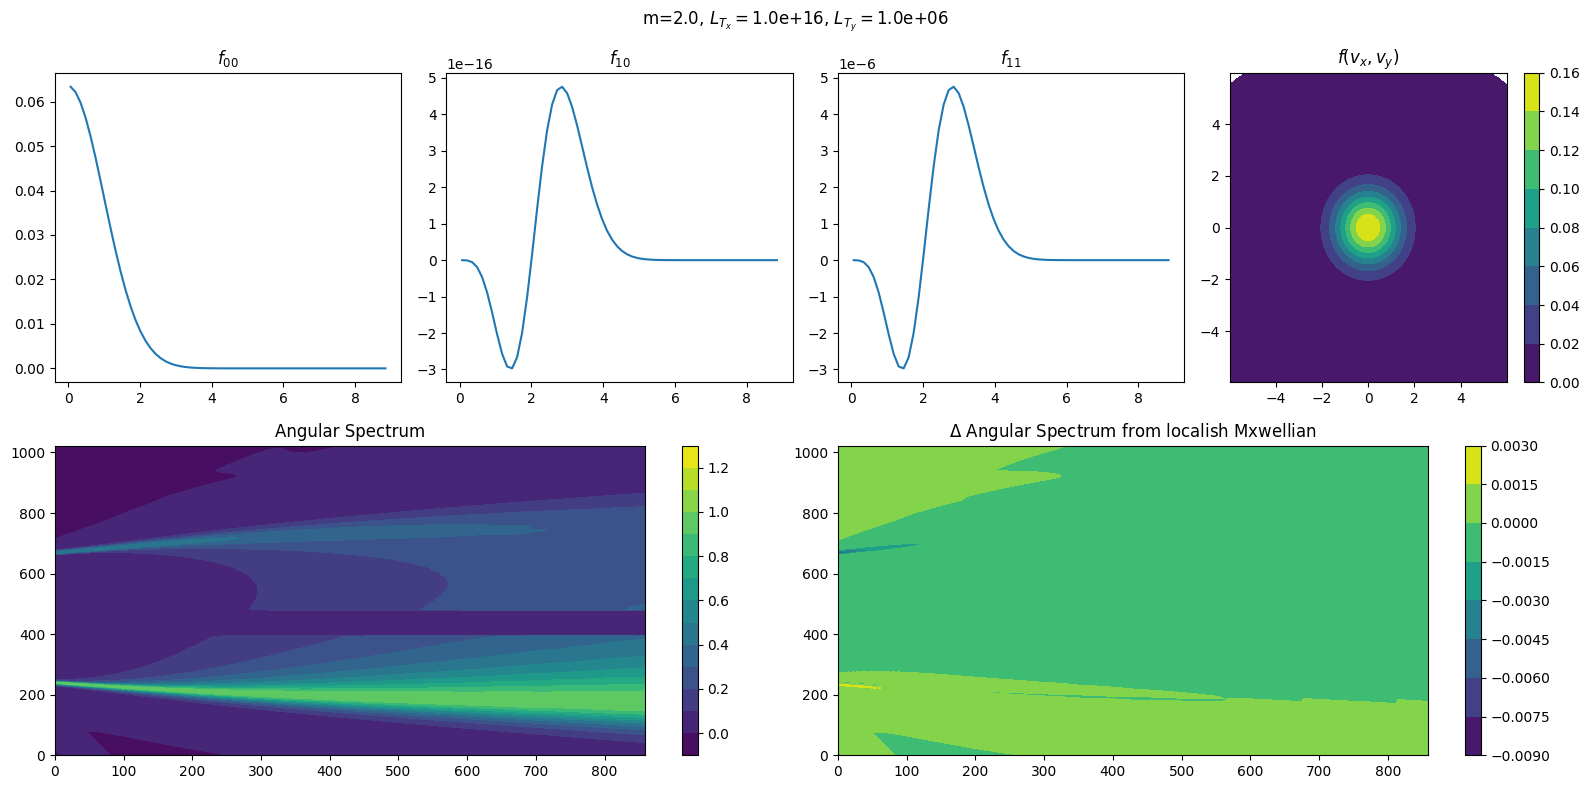

In [6]:
config["parameters"]["electron"]["fe"]["params"]["init_m"] = m = 2.0
config["parameters"]["electron"]["fe"]["params"]["LTx"] = LTx = 1e16
config["parameters"]["electron"]["fe"]["params"]["LTy"] = LTy = 1e6
ts_diag = ThomsonScatteringDiagnostic(config, scattering_angles=sas)
ts_params = ThomsonParams(config["parameters"], num_params=1, batch=False)
pThryE, ThryI, lamAxisE, lamAxisI = ts_diag(ts_params, dummy_batch)
# make a grid spec in which the first row has two plots and the second row has one plot
# Define the GridSpec
f00 = ts_params.electron.distribution_functions.get_f00()
vx = ts_params.electron.distribution_functions.vx
fvxvy = ts_params.electron.distribution_functions()

from matplotlib import gridspec
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
fig = plt.figure(figsize=(16, 8), tight_layout=True)
vr = ts_params.electron.distribution_functions.vr

# First row: Two plots
ax1 = fig.add_subplot(gs[0, 0])  # First plot in the first row
ax2 = fig.add_subplot(gs[0, 1])  # Second plot in the first row
ax3 = fig.add_subplot(gs[0, 2])  # Second plot in the first row
ax4 = fig.add_subplot(gs[0, 3])  # Second plot in the first row

# Second row: One plot spanning two columns
ax5 = fig.add_subplot(gs[1, :2])  # Single plot span
ax6 = fig.add_subplot(gs[1, 2:])  # Single plot span

# fig, ax = plt.subplots(2, 2, figsize=(10, 4), tight_layout=True)
c = ax5.contourf(pThryE.T, levels=np.linspace(-0.1, 1.3, 15))
ax5.set_title("Angular Spectrum")
fig.colorbar(c)

c = ax6.contourf((pThryE-ThryE).T)
ax6.set_title("$\Delta$ Angular Spectrum from localish Mxwellian")
fig.colorbar(c)

ax1.plot(vr, ts_params.electron.distribution_functions.get_f00())
ax1.set_title("$f_{00}$")
ax2.plot(vr, ts_params.electron.distribution_functions.flm[1][0] * f00)
ax2.set_title("$f_{10}$")
ax3.plot(vr, ts_params.electron.distribution_functions.flm[1][1] * f00)
ax3.set_title("$f_{11}$")
c = ax4.contourf(vx, vx, fvxvy)
ax4.set_title("$f(v_x, v_y)$")
fig.colorbar(c)
fig.suptitle(f"m={m:.1f}" + ", $L_{T_x} =$" + f"{LTx:.1e}" + ", $L_{T_y} = $" + f"{LTy:.1e}")
fig.savefig(f"arts2d-m={m:.1f}-LTx={LTx:.1e}-LTy={LTy:.1e}.png", bbox_inches="tight")


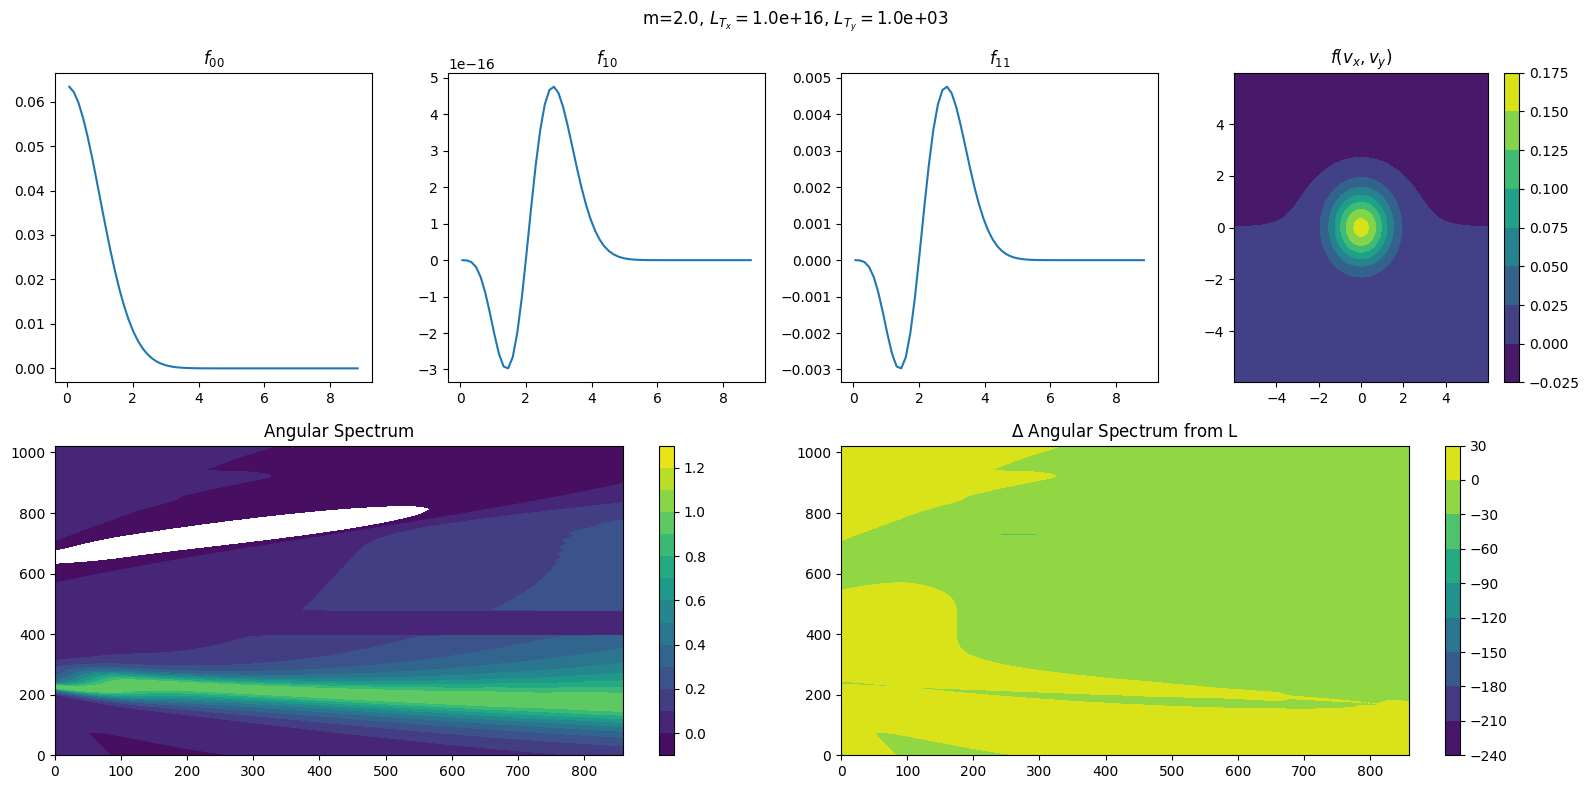

In [9]:
from jax.scipy.special import gamma, sph_harm
from jax import numpy as jnp, vmap 
v_sph_harm = vmap(sph_harm, in_axes=(None, None, 0, 0, None))
th = ts_params.electron.distribution_functions.th

phi = jnp.arccos(mvy/jnp.abs(mvy))

_sph_harm = v_sph_harm(
                    jnp.array([1]), jnp.array([0]), phi.flatten(), jnp.abs(th.reshape(-1, order="C")), 2
                ).reshape(ts_params.electron.distribution_functions.vr_vxvy.shape, order="C")



NameError: name 'mvy' is not defined

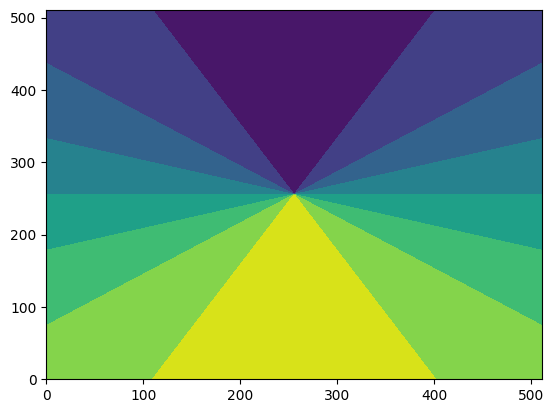

In [38]:
plt.contourf(_sph_harm)

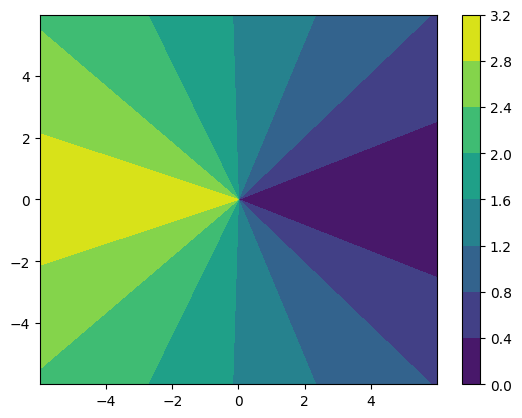